In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import random

In [2]:
plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

### Adding random seed

In [3]:
# Set random seed for reproducibility
torch.manual_seed(17)
np.random.seed(17)
random.seed(17)

# 1D Gaussian process in Python
reference: https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/main/CH02/01%20-%20Gaussian%20processes.ipynb

In [4]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [5]:
train_x = torch.rand(size = (3,1)) * 6 -1
train_y = forrester_1d(train_x)

In [6]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

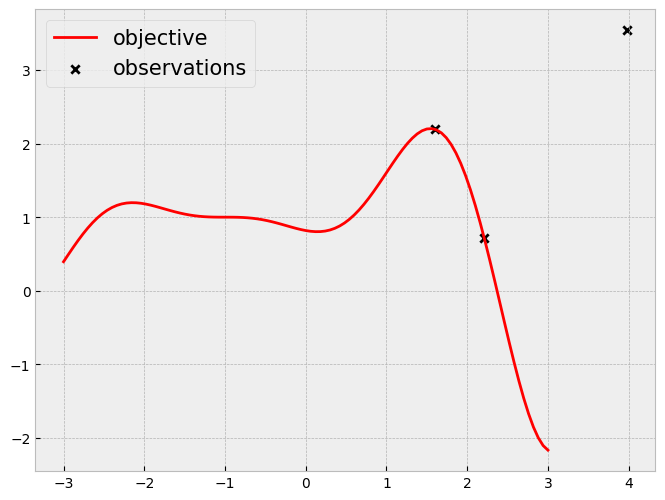

In [7]:
plt.figure(figsize=(8, 6))

plt.plot(xs, ys, label="objective", c="r")
plt.scatter(train_x, train_y, marker="x", c="k", label="observations")
#plt.xlim(-3,3)
plt.legend(fontsize=15);

### Define the GP model

-  For creating an MVN distribution with a mean vector and a covariance matrix

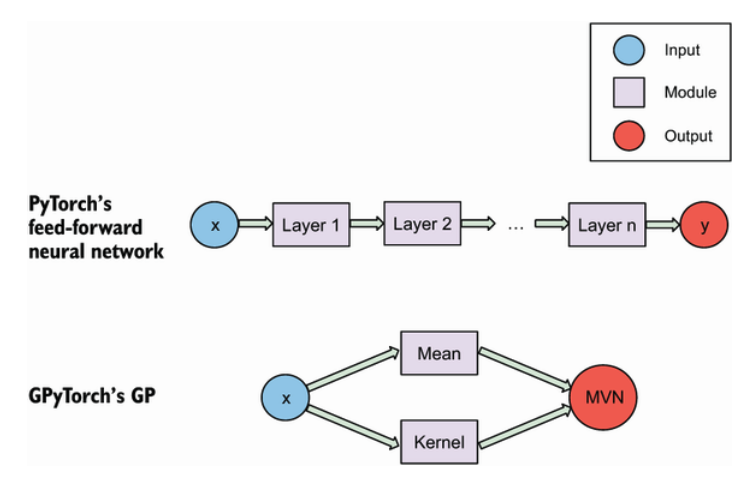

In [8]:
class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean() # mean function
        self.covar_module = gpytorch.kernels.RBFKernel() # covariance function, using RBF here

    def forward(self, x): # passing both mean and covar functions to the GP model at once 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Make prediction with the GP model
- likelihood(): pass in a likelihood function by gpytorch.likelihoods.GaussianLikelihood()
- model(train_x, train_y, likelihood): To initialize a GP, we dont have to pass in the train_x and train_y

### Hyperparameters for the GP model

In [9]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood() # MLE
model = BaseGPModel(None, None, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [10]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    torch.manual_seed(0)
    samples = predictive_distribution.sample(torch.Size([5]))

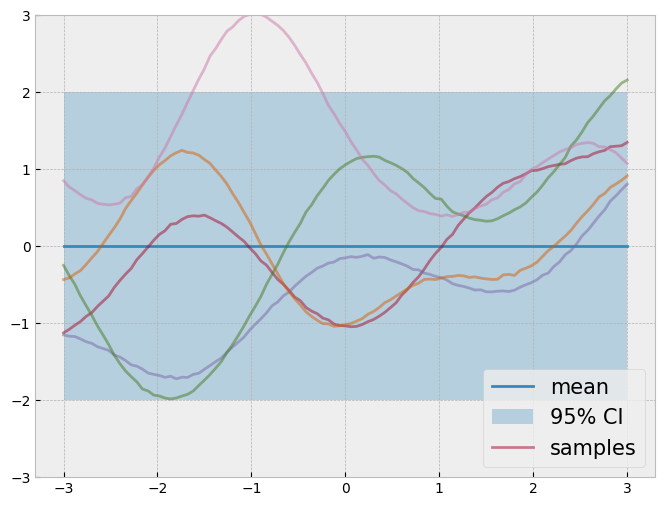

In [11]:
plt.figure(figsize=(8, 6))

plt.plot(xs, predictive_mean.detach(), label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.ylim(-3, 3)

plt.legend(fontsize=15);

### Now, pass in the train_x and train_y

In [12]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    torch.manual_seed(0)
    samples = predictive_distribution.sample(torch.Size([5]))

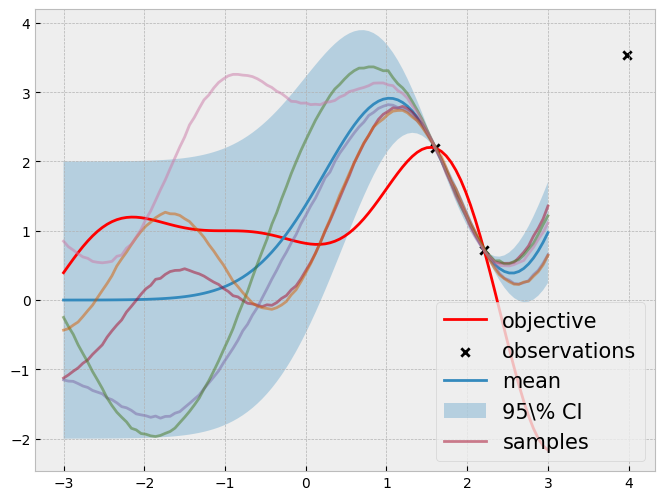

In [14]:
plt.figure(figsize=(8, 6))

plt.plot(xs, ys, label="objective", c="r")
plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

plt.plot(xs, predictive_mean, label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95\% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.legend(fontsize=15);

2D GP

In [16]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

## Copying the data generation from the original

In [ ]:
# Data Generation
nv = 20
xv = np.linspace(-5., 5., nv)
yv = np.linspace(-5., 5., nv)
x, y = np.meshgrid(xv, yv)
z = (x - 3.)**2 + 2.*x*y + (2.*y + 3.)**2 - 3.

In [ ]:
#def function(x,y):
#    z = (x - 3.)**2 + 2.*x*y + (2.*y + 3.)**2 - 3.
#    return z

In [ ]:
#z = function(x,y)

## Adding Gaussian Noise 

In [ ]:
noise_level = 5.
z_noisy = z + np.random.normal(size=x.shape) * noise_level

scikit-learn expects each input and output as column vectors, so we must reshape the grid:

In [ ]:
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1, 1)

In [ ]:
# Define the GP Model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [ ]:
# Data Splitting and Normalization
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)
y_mean = Y_train.mean()
y_std = Y_train.std()
Y_train_normalized = (Y_train - y_mean) / y_std

train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(Y_train_normalized).float().squeeze()
X_tensor = torch.from_numpy(X).float()

In [ ]:
# Initialize likelihood and model with constraints
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0)
)
model = GPModel(train_x, train_y, likelihood)


In [ ]:
# Set Hyperparameters with Constraints
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0, 1.0])
model.covar_module.base_kernel.register_prior(
    "lengthscale_prior",
    gpytorch.priors.NormalPrior(1.0, 1.0),
    "lengthscale"
)
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)

model.covar_module.outputscale = 1.0
model.covar_module.register_prior(
    "outputscale_prior",
    gpytorch.priors.NormalPrior(1.0, 1.0),
    "outputscale"
)
model.covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.01, 100.0)

likelihood.noise = 0.1


In [ ]:
# Train the Model
model.train()
likelihood.train()

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    return loss

for i in range(50):
    optimizer.step(closure)

In [ ]:
# Make Predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_tensor))
    prediction_mean = observed_pred.mean.numpy()
    prediction_std = observed_pred.stddev.numpy()

zfit_original = prediction_mean * y_std + y_mean
zstd_original = prediction_std * y_std

zfit = zfit_original.reshape(x.shape)
zstd = zstd_original.reshape(x.shape)

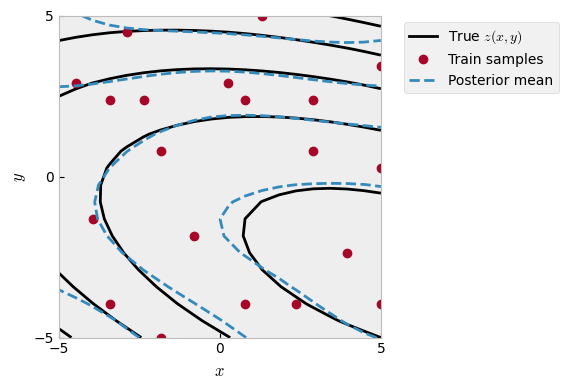

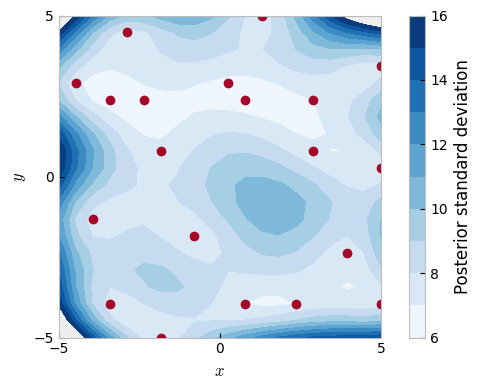

In [ ]:
# Plot Posterior Mean
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_aspect('equal')
ax.set_xticks((-5, 0, 5))
ax.set_yticks((-5, 0, 5))
ax.grid(False)

lev = np.linspace(0., 250., 6)
ax.contour(x, y, z, lev, colors='k')  # Truth
ax.plot(*X_train.T, 'o', color="C1")  # Training samples
ax.contour(x, y, zfit, lev, colors='C0', linestyles='dashed')  # Posterior mean

truth_line = mlines.Line2D([], [], color='black', label='True $z(x,y)$')
sample_line = mlines.Line2D([], [], color='C1', marker="o", linestyle="none", label='Train samples')
mean_line = mlines.Line2D([], [], color='C0', linestyle="--", label='Posterior mean')
ax.legend(handles=[truth_line, sample_line, mean_line], bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig('gpr_posterior_mean.svg')

# Plot Posterior Standard Deviation
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_aspect('equal')
ax.set_xticks((-5, 0, 5))
ax.set_yticks((-5, 0, 5))
ax.grid(False)

ax.plot(*X_train.T, 'o', color="C1")  # Training samples
lev = np.linspace(6., 16., 11)
hc = ax.contourf(x, y, zstd, lev)  # Posterior std

hcb = plt.colorbar(hc)
hcb.ax.grid(False)
hcb.set_label('Posterior standard deviation')

plt.tight_layout()
plt.savefig('gpr_posterior_std.svg')

With EI

In [17]:
# Simulated ground-truth function (Branin or similar)
def ground_truth(X_np):
    x1 = X_np[:, 0]
    x2 = X_np[:, 1]
    return (x2 - (5.1 / (4 * np.pi**2)) * x1**2 + (5 / np.pi) * x1 - 6)**2 + \
           10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10

In [18]:
# Domain and meshgrid
x1 = np.linspace(-5, 10, 50)
x2 = np.linspace(0, 15, 50)
x, y = np.meshgrid(x1, x2)
z = ground_truth(np.column_stack([x.flatten(), y.flatten()])).reshape(x.shape)


In [19]:
# Add noise to ground truth
noise_level = 5.0
z_noisy = z + np.random.normal(size=x.shape) * noise_level
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1, 1)

In [20]:
# Split and normalize
X_train, _, Y_train, _ = train_test_split(X, Z, test_size=0.95, random_state=0)
y_mean = Y_train.mean()
y_std = Y_train.std()
Y_train_normalized = (Y_train - y_mean) / y_std

train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(Y_train_normalized).float()

In [21]:
# Define synthetic black-box function with noise + normalization
def blackbox_2d(x_tensor):
    x_np = x_tensor.detach().numpy()
    z_clean = ground_truth(x_np)
    z_noisy = z_clean + np.random.normal(scale=noise_level, size=z_clean.shape)
    z_norm = (z_noisy - y_mean) / y_std
    return torch.tensor(z_norm, dtype=torch.float32).unsqueeze(-1)


In [22]:
# BoTorch Expected Improvement Loop
bounds = torch.tensor([[-5.0, 0.0], [10.0, 15.0]], dtype=torch.float32)
num_iterations = 10

for i in range(num_iterations):
    print(f"\n=== Iteration {i+1} ===")
    print("Best observed (normalized):", train_y.max().item())

    # Fit GP model
    model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Acquisition Function: EI
    ei = ExpectedImprovement(model=model, best_f=train_y.max())

    # Optimize EI
    next_x, _ = optimize_acqf(
        acq_function=ei,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=50,
    )

    # Evaluate black-box at proposed point
    next_y = blackbox_2d(next_x)

    # Append new data
    train_x = torch.cat([train_x, next_x], dim=0)
    train_y = torch.cat([train_y, next_y.squeeze()], dim=0)

    print("Next x:", next_x.detach().numpy())
    print("Next y (normalized):", next_y.item())


=== Iteration 1 ===
Best observed (normalized): 3.4879519939422607


/var/folders/mg/l5f3xml94wjb2ks03kfgl9840000gn/T/ipykernel_6427/721303002.py:10: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(train_x, train_y)
/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://ar

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

# Set default dtype to double for BoTorch compatibility
torch.set_default_dtype(torch.float64)

# Simulated ground-truth function (Branin or similar)
def ground_truth(X_np):
    x1 = X_np[:, 0]
    x2 = X_np[:, 1]
    return (x2 - (5.1 / (4 * np.pi**2)) * x1**2 + (5 / np.pi) * x1 - 6)**2 + \
           10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10

# Domain and meshgrid
x1 = np.linspace(-5, 10, 50)
x2 = np.linspace(0, 15, 50)
x, y = np.meshgrid(x1, x2)
z = ground_truth(np.column_stack([x.flatten(), y.flatten()])).reshape(x.shape)

# Add noise to ground truth
noise_level = 5.0
z_noisy = z + np.random.normal(size=x.shape) * noise_level
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1, 1)

# Split and normalize
X_train, _, Y_train, _ = train_test_split(X, Z, test_size=0.95, random_state=0)
y_mean = Y_train.mean()
y_std = Y_train.std()
Y_train_normalized = (Y_train - y_mean) / y_std

# Convert to torch double tensors
train_x = torch.from_numpy(X_train).double()
train_y = torch.from_numpy(Y_train_normalized).double().squeeze()

# Normalize input to unit cube
x_min = train_x.min(0).values
x_max = train_x.max(0).values
train_x_scaled = (train_x - x_min) / (x_max - x_min)
bounds = torch.tensor([[0., 0.], [1., 1.]], dtype=torch.double)

# Black-box function (uses raw inputs, scales inside)
def blackbox_2d(x_scaled):
    # Unnormalize back to real space
    x_real = x_scaled * (x_max - x_min) + x_min
    x_np = x_real.detach().numpy()
    z_clean = ground_truth(x_np)
    z_noisy = z_clean + np.random.normal(scale=noise_level, size=z_clean.shape)
    z_norm = (z_noisy - y_mean) / y_std
    return torch.tensor(z_norm, dtype=torch.double).unsqueeze(-1)

# EI loop
num_iterations = 10

for i in range(num_iterations):
    print(f"\n=== Iteration {i+1} ===")
    print("Best observed (normalized):", train_y.max().item())

    # Fit GP model
    model = SingleTaskGP(train_x_scaled, train_y.unsqueeze(-1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Use LogExpectedImprovement (numerically stable EI)
    ei = LogExpectedImprovement(model=model, best_f=train_y.max())

    # Optimize acquisition
    next_x_scaled, _ = optimize_acqf(
        acq_function=ei,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=50,
    )

    # Evaluate at new point
    next_y = blackbox_2d(next_x_scaled)

    # Update dataset
    train_x_scaled = torch.cat([train_x_scaled, next_x_scaled], dim=0)
    train_y = torch.cat([train_y, next_y.view(-1)], dim=0)


    print("Next x (scaled):", next_x_scaled.detach().numpy())
    print("Next y (normalized):", next_y.item())



=== Iteration 1 ===
Best observed (normalized): 3.5109488837748053
Next x (scaled): [[0. 0.]]
Next y (normalized): 3.880806580288249

=== Iteration 2 ===
Best observed (normalized): 3.880806580288249
Next x (scaled): [[0. 0.]]
Next y (normalized): 4.055743637553314

=== Iteration 3 ===
Best observed (normalized): 4.055743637553314
Next x (scaled): [[0. 0.]]
Next y (normalized): 4.040538956032628

=== Iteration 4 ===
Best observed (normalized): 4.055743637553314
Next x (scaled): [[0. 0.]]
Next y (normalized): 3.966407937697606

=== Iteration 5 ===
Best observed (normalized): 4.055743637553314
Next x (scaled): [[0. 0.]]
Next y (normalized): 3.7908630623991955

=== Iteration 6 ===
Best observed (normalized): 4.055743637553314
Next x (scaled): [[0. 0.]]
Next y (normalized): 4.013622898695148

=== Iteration 7 ===
Best observed (normalized): 4.055743637553314
Next x (scaled): [[0. 0.]]
Next y (normalized): 3.9517098674599183

=== Iteration 8 ===
Best observed (normalized): 4.055743637553314


=== Iteration 1 ===
Best observed (normalized): 3.520186347948011


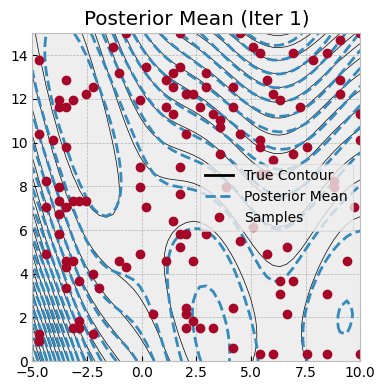


=== Iteration 2 ===
Best observed (normalized): 3.520186347948011


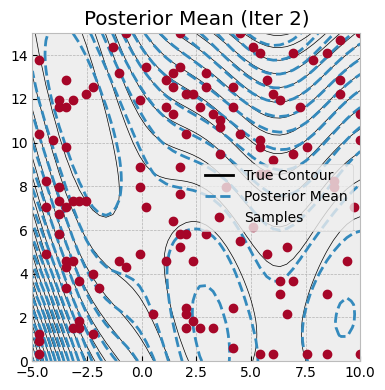


=== Iteration 3 ===
Best observed (normalized): 3.821822430863605


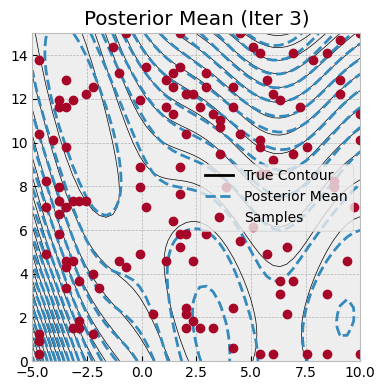


=== Iteration 4 ===
Best observed (normalized): 3.821822430863605


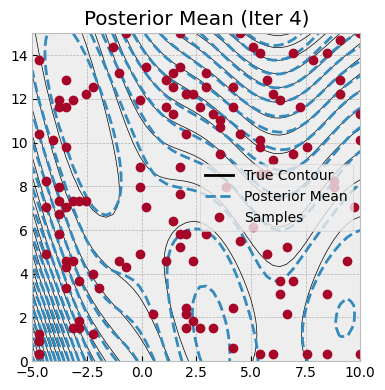


=== Iteration 5 ===
Best observed (normalized): 3.821822430863605


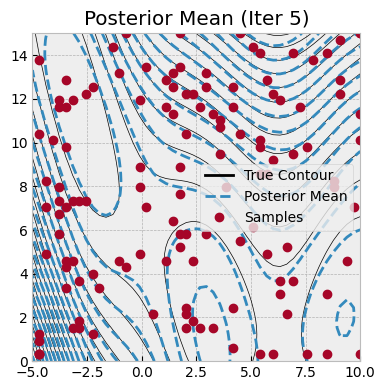


=== Iteration 6 ===
Best observed (normalized): 3.8767601480049128


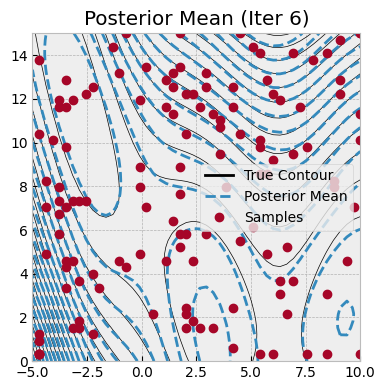


=== Iteration 7 ===
Best observed (normalized): 3.8767601480049128


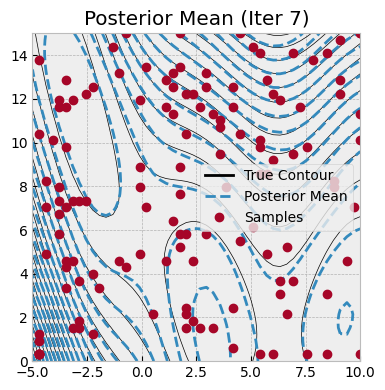


=== Iteration 8 ===
Best observed (normalized): 3.8767601480049128


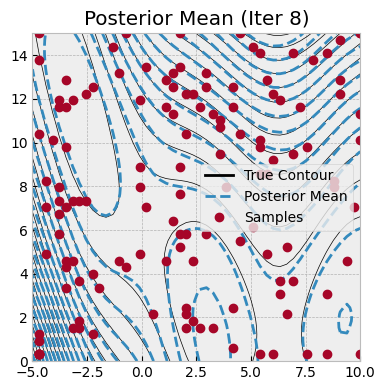


=== Iteration 9 ===
Best observed (normalized): 3.8767601480049128


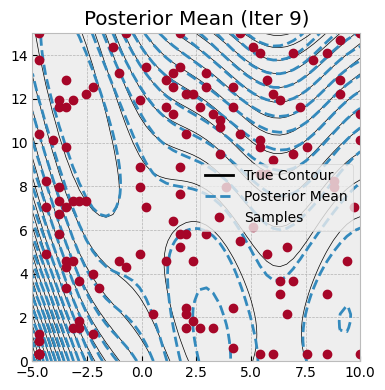


=== Iteration 10 ===
Best observed (normalized): 3.8767601480049128


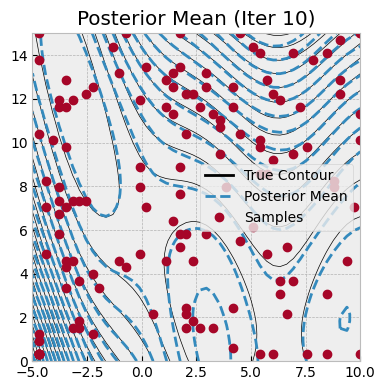

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
import matplotlib.lines as mlines

torch.set_default_dtype(torch.float64)

# Ground truth: Branin-like function
def ground_truth(X_np):
    x1 = X_np[:, 0]
    x2 = X_np[:, 1]
    return (x2 - (5.1 / (4 * np.pi**2)) * x1**2 + (5 / np.pi) * x1 - 6)**2 + \
           10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10

# Domain and meshgrid
x1 = np.linspace(-5, 10, 50)
x2 = np.linspace(0, 15, 50)
x, y = np.meshgrid(x1, x2)
z = ground_truth(np.column_stack([x.flatten(), y.flatten()])).reshape(x.shape)

# Add noise
noise_level = 5.0
z_noisy = z + np.random.normal(size=x.shape) * noise_level
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1, 1)

# Train-test split
X_train, _, Y_train, _ = train_test_split(X, Z, test_size=0.95, random_state=0)
y_mean = Y_train.mean()
y_std = Y_train.std()
Y_train_normalized = (Y_train - y_mean) / y_std

# Convert to torch double
train_x = torch.from_numpy(X_train).double()
train_y = torch.from_numpy(Y_train_normalized).double().squeeze()

# Normalize input to unit cube
x_min = train_x.min(0).values
x_max = train_x.max(0).values
train_x_scaled = (train_x - x_min) / (x_max - x_min)
bounds = torch.tensor([[0., 0.], [1., 1.]], dtype=torch.double)

# Define black-box function
def blackbox_2d(x_scaled):
    x_real = x_scaled * (x_max - x_min) + x_min
    x_np = x_real.detach().numpy()
    z_clean = ground_truth(x_np)
    z_noisy = z_clean + np.random.normal(scale=noise_level, size=z_clean.shape)
    z_norm = (z_noisy - y_mean) / y_std
    return torch.tensor(z_norm, dtype=torch.double).unsqueeze(-1)

# Grid for plotting
X_plot = torch.from_numpy(X).double()
X_plot_scaled = (X_plot - x_min) / (x_max - x_min)

# Optimization loop
num_iterations = 10
for i in range(num_iterations):
    print(f"\n=== Iteration {i+1} ===")
    print("Best observed (normalized):", train_y.max().item())

    # Fit GP
    model = SingleTaskGP(train_x_scaled, train_y.unsqueeze(-1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Acquisition function
    ei = LogExpectedImprovement(model=model, best_f=train_y.max())
    next_x_scaled, _ = optimize_acqf(ei, bounds=bounds, q=1, num_restarts=10, raw_samples=50)

    # Evaluate and update
    next_y = blackbox_2d(next_x_scaled)
    train_x_scaled = torch.cat([train_x_scaled, next_x_scaled], dim=0)
    train_y = torch.cat([train_y, next_y.view(-1)], dim=0)

    # Predict on full grid
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(X_plot_scaled)
        pred_mean = posterior.mean.numpy().reshape(x.shape)
        pred_std = posterior.variance.sqrt().numpy().reshape(x.shape)

    # Plot posterior mean
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f"Posterior Mean (Iter {i+1})")
    ax.contour(x, y, z, levels=20, colors='k', linewidths=0.5)
    ax.contour(x, y, pred_mean * y_std + y_mean, levels=20, colors='C0', linestyles='--')
    ax.plot((train_x_scaled * (x_max - x_min) + x_min)[:, 0].numpy(),
            (train_x_scaled * (x_max - x_min) + x_min)[:, 1].numpy(),
            'o', color='C1')
    ax.set_xlim(-5, 10)
    ax.set_ylim(0, 15)
    ax.set_aspect('equal')
    ax.legend(handles=[
        mlines.Line2D([], [], color='black', label='True Contour'),
        mlines.Line2D([], [], color='C0', linestyle='--', label='Posterior Mean'),
        mlines.Line2D([], [], color='C1', marker='o', linestyle='None', label='Samples')
    ])
    plt.tight_layout()
    plt.show()
